
# Parameterization choices for hierarchical models:  centered, non-centered

### Overview

This note expands on the section in Bob Carpenter's most excellent case study
[Hierarchical Partial Pooling for Repeated Binary Trials](https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html) which introduces the non-centered parameterization of a hierarchical model.

Hierarchical models provide partial pooling of information across parameters
according to group membership.
The hierarchical model provides group-level parameters
which influence the fixed-effects parameters
(individual distributions on the group members).
For datasets where the groups have relatively few members,
MCMC samplers cannot easily explore the resulting sampling density.
The non-centered parameterization mitigates this problem by decoupling
the group-level and fixed-effects parameters in the sampling distribution.

The case study dataset is taken from baseball, consisting of
the number of hits and at-bats for a set of Major League Baseball players.
While individual players have differing batting abilities, they are taken from the population
of MLB baseball players.
Therefore, it makes sense to build a hierarchical model of player ability.

Abstractly, the data consists of `N` observations `y`, where each observation $y_n$ is
the number of successes for ${player}_n$ in `K` trials.
The dataset is small:  18 players ($N = 18$), 45 at-bats ($K = 45$).
The model estimates ${\theta}_n$, each player's chance of success for an at-bat.
($\theta * 1000$ is a player's "batting average".)
It does so by recasting the problem in terms of parameter $\alpha$,
a player's log-odds of success.
This makes it much easier to expand the model by adding
more fixed effects and other multilevel effects.
The hierarchical model puts a normal prior with group-level parameters
$\mu$ and $\sigma$ on the estimates for parameter $\alpha$.
The hierarchical model pulls the individual player estimates towards the group mean $\mu$.

The centered parameteriation for a hierarchical model corresponds directly to
the data structure:   the individual-level parameter `alpha` - a player's log-odds of success
is given a prior distribution specified in terms of the group-level parameters:
`alpha ~ normal(mu, sigma)`.

The non-centered parameterization is recommended for hierarchical models
where the groups have relatively few members.
The trick is to decouple `alpha`, `mu`, and `sigma` in the sampling distribution
by reparameterization.

There are two ways to do this:

- a non-centered parameterization with standard normal prior on parameter `alpha_std` and auxiliary variable `alpha`.
- a non-centered parameterization using an affine transform on parameter `alpha`.

In this note we show models for each and then plot the result.

### Packages used in this notebook

We use [CmdStanPy](https://mc-stan.org/cmdstanpy) to do the model fitting and plot the results using [plotnine](https://plotnine.readthedocs.io/en/stable/), a ggplot2-like Python package.
Pandas and NumPy are also used for data munging.

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

from cmdstanpy import CmdStanModel

In [2]:
theme_set(
  theme_grey() + 
  theme(text=element_text(size=10),
        plot_title=element_text(size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8)
       )
)

### Baseball Data:  Number of hits in 45 at-bats for 18 MLB players in 1971

In [3]:
with open('efron-morris-75-data.tsv') as tsv_file:
    df = pd.read_csv("efron-morris-75-data.tsv", sep="\t")
df.style.hide_index().format(precision=3)

FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
Roberto,Clemente,45,18,0.400,367,0.346,412,145,0.352
Frank,Robinson,45,17,0.378,426,0.298,471,144,0.306
Frank,Howard,45,16,0.356,521,0.276,566,160,0.283
Jay,Johnstone,45,15,0.333,275,0.222,320,76,0.238
Ken,Berry,45,14,0.311,418,0.273,463,128,0.276
Jim,Spencer,45,14,0.311,466,0.270,511,140,0.274
Don,Kessinger,45,13,0.289,586,0.265,631,168,0.266
Luis,Alvarado,45,12,0.267,138,0.210,183,41,0.224
Ron,Santo,45,11,0.244,510,0.269,555,148,0.267
Ron,Swaboda,45,11,0.244,200,0.230,245,57,0.233


In [6]:
baseball_data = {"N": df.shape[0],
                 "K": df['At-Bats'],
                 "y": df['Hits'],
                 "K_new": df['RemainingAt-Bats'],
                 "y_new": df['SeasonHits']-df['Hits']}

M = 10000  # desired number of draws from the posterior

# ggplot2 x_y plot with axis labels and optional title
def scatter_plot(df, x_lab, y_lab, title=''):
  return (ggplot(df, aes('x', 'y')) +
          geom_point(alpha=0.2) +
          xlab(x_lab) +
          ylab(y_lab) +
          ggtitle(title) +
          theme(figure_size=(8,6)))

## The Model

The model we are interested in is a hierarchical model
with a *normal prior* on the *log odds of success*.
The mathematical model specification is

$$
p(y_n \, | \, K_n, \alpha_n) 
\ = \ \mathsf{Binomial}(y_n \, | \, K_n, \ \mathrm{logit}^{-1}(\alpha_n))
$$

with a simple normal hierarchical prior

$$
p(\alpha_n \, | \, \mu, \sigma)
= \mathsf{Normal}(\alpha_n \, | \, \mu, \sigma).
$$

a weakly informative hyperprior for $\mu$

$$
p(\mu) = \mathsf{Normal}(\mu \, | \, -1, 1),
$$

and a half normal prior on $\sigma$

$$
p(\sigma)
\ = \ 2 \, \mathsf{Normal}(\sigma \, | \, 0, 1)
\ \propto \ \mathsf{Normal}(\sigma \, | \, 0, 1).
$$

### Centered Parameterization

The Stan program `hier-logit-centered.stan` is a straightforward encoding of
a hierarchical model with a *normal prior* on the *log odds of success*,
but this is not the optimal way to code this model in Stan, as we will soon demonstrate.

```
parameters {
  real mu;                       // population mean of success log-odds
  real<lower=0> sigma;           // population sd of success log-odds
  vector[N] alpha;               // success log-odds
}
model {
  mu ~ normal(-1, 1);               // hyperprior
  sigma ~ normal(0, 1);             // hyperprior
  alpha ~ normal(mu, sigma);        // prior (hierarchical)
  y ~ binomial_logit(K, alpha);     // likelihood
}
```

The chance of success $\theta$ is computed as a generated quantity.

```
generated quantities {
  vector[N] theta = inv_logit(alpha);
}
```

In [7]:
hier_logit_centered_model = CmdStanModel(stan_file='hier-logit-centered.stan')
print(hier_logit_centered_model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


data {
  int<lower=0> N; // items
  array[N] int<lower=0> K; // initial trials
  array[N] int<lower=0> y; // initial successes
}
parameters {
  real mu; // population mean of success log-odds
  real<lower=0> sigma; // population sd of success log-odds
  vector[N] alpha; // success log-odds
}
model {
  mu ~ normal(-1, 1); // hyperprior
  sigma ~ normal(0, 1); // hyperprior
  alpha ~ normal(mu, sigma); // prior (hierarchical)
  y ~ binomial_logit(K, alpha); // likelihood
}
generated quantities {
  vector[N] theta = inv_logit(alpha);
}



In [8]:
fit_centered = hier_logit_centered_model.sample(
    data=baseball_data,
    iter_sampling=int(M/4),
    seed=54321)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


The variable `theta` is the per-player chance of success, i.e., `theta * 1000` is their batting average.  These range from 240 - 270, which is in line with what we expect from major league baseball players.

In [7]:
fit_centered.summary(sig_figs=3).round(decimals=3).filter(
    regex=r'mu|sigma|theta', axis="index")

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
mu,-1.030,0.002,0.094,-1.180,-1.030,-0.873,2230.0,3210.0,1.00
sigma,0.189,0.004,0.103,0.054,0.173,0.382,696.0,999.0,1.01
theta[1],0.298,0.001,0.045,0.239,0.291,0.382,2188.0,3139.0,1.00
theta[2],0.292,0.001,0.041,0.237,0.286,0.370,2826.0,4054.0,1.00
theta[3],0.287,0.001,0.039,0.233,0.282,0.360,3337.0,4788.0,1.00
theta[4],0.282,0.001,0.038,0.228,0.278,0.350,4080.0,5854.0,1.00
theta[5],0.277,0.001,0.036,0.224,0.273,0.342,4967.0,7126.0,1.00
theta[6],0.277,0.001,0.037,0.222,0.273,0.344,5192.0,7449.0,1.00
theta[7],0.271,0.000,0.036,0.216,0.269,0.332,6397.0,9179.0,1.00


The reported Eff values for `sigma` are low and the R_hat value is above 1.   CmdStan's `diagnose` method indicates that this model had problems fitting the data.

In [9]:
print(fit_centered.diagnose())

Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpnfv9g598/hier-logit-centered-20220127184534_1.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpnfv9g598/hier-logit-centered-20220127184534_2.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpnfv9g598/hier-logit-centered-20220127184534_3.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpnfv9g598/hier-logit-centered-20220127184534_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
76 of 10000 (0.76%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.22, is below the nominal threshold of 0.3 which suggests that HMC may have trouble expl

### The Funnel

With a small amount of data, the sampler cannot properly determine how much of the observed variance in the data is individual-level variance or group-level variance.  It displays low ESS and poor R-hat for `sigma`.
When we plot the estimate of `alpha[1]`, the log-odds success for player 1, against `log(sigma)`, the group-level variance, the range on the y axis is (-4, 0) and there is a clear funnel shape with many draws at the bottom of the neck of the funnel.

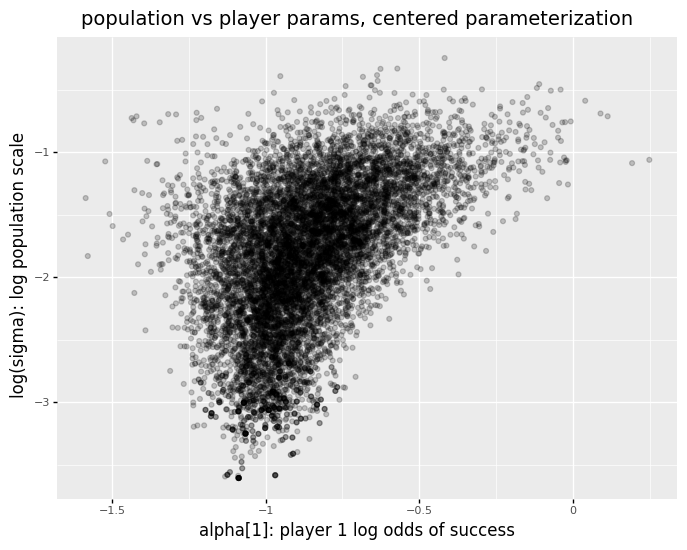

<ggplot: (8777772467869)>

In [10]:
df_x_y = pd.DataFrame(
    data={'x': fit_centered.stan_variable('alpha')[:,0],
          'y': np.log(fit_centered.stan_variable('sigma'))
         }
)

scatter_plot(df_x_y,
         x_lab = "alpha[1]: player 1 log odds of success",
         y_lab = "log(sigma): log population scale",
         title = "population vs player params, centered parameterization")

## The Non-Centered Parameterization 

Instead of a hierarchical prior, 
the non-centered parameterization takes a standard unit normal prior for a new variable,

$$
\alpha^{\mathrm{std}}_n = \frac{\alpha_n - \mu}{\sigma}.
$$

Then we can parameterize in terms of $\alpha^{\mathrm{std}}$, which
has a standard-normal distribution

$$
p(\alpha^{\mathrm{std}}_n) = \mathsf{Normal}(\alpha^{\mathrm{std}}_n \, | \, 0, 1).
$$

We can then define our original $\alpha$ as a derived quantity

$$
\alpha_n = \mu + \sigma \, \alpha^{\mathrm{std}}_n.
$$

This decouples the sampling distribution
for $\alpha^{\mathrm{std}}$ from $\mu$ and $\sigma$, greatly reducing
their correlation in the posterior.
*The sampler only knows about the model parameters*.
Since the prior on parameter $\alpha$ is not specified in terms of parameters $\mu$ and $\sigma$, the sampler can move more freely along their axes, and therefore explore the posterior more fully.
Although we decouple the parameters, we still need to share information
between the group-level and individual level parameters;
this is done using auxiliary variables, either transformed parameters or
directly in the model block.




###  Non-centered parameterization using a standard normal distribution

Prior to Stan 2.19, a Stan implementation directly encoded the above reparameterization,
introducing a new variable `alpha_std` which has a standard normal distribution,
thus decoupling the sampling distribution of `alpha_std` from `mu` and `sigma`.
```
parameters {
  real mu; // population mean of success log-odds
  real<lower=0> sigma; // population sd of success log-odds
  vector[N] alpha_std; // success log-odds (standardized)
}
model {
  mu ~ normal(-1, 1); // hyperprior
  sigma ~ normal(0, 1); // hyperprior
  alpha_std ~ normal(0, 1); // prior (hierarchical)
  y ~ binomial_logit(K, mu + sigma * alpha_std); // likelihood
}
```

The Stan program "hier-logit-nc-std-norm.stan" contains this model.

###  Non-centered parameterization using an affine transform


Since Stan version 2.19, the Stan language's
[affine transform](https://mc-stan.org/docs/reference-manual/univariate-data-types-and-variable-declarations.html) construct provides a more efficient way to do this.
For a real variable, the affine transform $x\mapsto \mu + \sigma * x$ with offset $\mu$ and (positive) multiplier $\sigma$
is specified using a syntax like that used for upper/lower bounds, with keywords <code>offset</code>, <code>multiplier</code>.
Specifying the affine transform in the parameter declaration for 
$\alpha^{\mathrm{std}}$ eliminates the need for intermediate variables
and makes it easier to see the hierarchical structure of the model.

When the parameters to the prior for $\sigma$ are constants, the
normalization for the half-prior (compared to the full prior) is
constant and therefore does not need to be included in the notation.
This only works if the parameters to the density are data or constants;
if they are defined as parameters or as quantities depending on parameters,
then explicit truncation is required.

The Stan program `hier-logit-nc-affine-xform.stan` uses the affine-transform syntax to
specify the non-centered version of the hierarchical model
with a normal prior on the log odds of success.


```
parameters {
  real mu; // population mean of success log-odds
  real<lower=0> sigma; // population sd of success log-odds
  vector<offset=mu, multiplier=sigma>[N] alpha; // success log-odds
}
model {
  mu ~ normal(-1, 1); // hyperprior
  sigma ~ normal(0, 1); // hyperprior
  alpha ~ normal(mu, sigma); // prior (hierarchical)
  y ~ binomial_logit(K, alpha); // likelihood
}
```

### Fitting the standard normal reparameterization

The model `hier-logit-nc-std-norm.stan` fits the model using parameter `alpha_std`.  (*Full disclosure: depending on the random seed, it may report 1 or 2 divergences for a sample of 2500 draws; we've chosen a random seed that avoids this problem and have used it throughout this note.*)

In [10]:
nc_std_norm_model = CmdStanModel(stan_file='hier-logit-nc-std-norm.stan')
print(nc_std_norm_model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


data {
  int<lower=0> N; // items
  array[N] int<lower=0> K; // initial trials
  array[N] int<lower=0> y; // initial successes
}
parameters {
  real mu; // population mean of success log-odds
  real<lower=0> sigma; // population sd of success log-odds
  vector[N] alpha_std; // success log-odds (standardized)
}
model {
  mu ~ normal(-1, 1); // hyperprior
  sigma ~ normal(0, 1); // hyperprior
  alpha_std ~ normal(0, 1); // prior (hierarchical)
  y ~ binomial_logit(K, mu + sigma * alpha_std); // likelihood
}
generated quantities {
  vector[N] theta = inv_logit(mu + sigma * alpha_std);
  vector[N] alpha = mu + sigma * alpha_std;  // recover alpha
}



In [11]:
fit_nc_std_norm = nc_std_norm_model.sample(
    data=baseball_data,
    iter_sampling=int(M/4),
    seed=54321)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Again, we check for problems by running CmdStan's `diagnose` method.

In [12]:
print(fit_nc_std_norm.diagnose())

Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp08jiew0k/hier-logit-nc-std-norm-20220126224540_1.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp08jiew0k/hier-logit-nc-std-norm-20220126224540_2.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp08jiew0k/hier-logit-nc-std-norm-20220126224540_3.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp08jiew0k/hier-logit-nc-std-norm-20220126224540_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



The estimates for `mu`, `sigma`, `theta` and `alpha` are roughly the same as for the centered parameterization.  The non-centered parameterization results in a much larger effective sample size.

In [13]:
print("Centered parameterization")
print(fit_centered.summary(sig_figs=3).round(decimals=3).filter(
    ["mu", "sigma",
     "theta[1]", "theta[5]", "theta[10]", "theta[18]",
     "alpha[1]", "alpha[5]", "alpha[10]", "alpha[18]"],
    axis="index"))

print("\nNon-centered parameterization, std_normal reparameterization")
print(fit_nc_std_norm.summary(sig_figs=3).round(decimals=3).filter(
    ["mu", "sigma",
     "theta[1]", "theta[5]", "theta[10]", "theta[18]",
     "alpha[1]", "alpha[5]", "alpha[10]", "alpha[18]"],
    axis="index"))

Centered parameterization
            Mean   MCSE  StdDev     5%    50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                        
mu        -1.030  0.002   0.094 -1.180 -1.030 -0.873  2230.0   3210.0   1.00
sigma      0.189  0.004   0.103  0.054  0.173  0.382   696.0    999.0   1.01
theta[1]   0.298  0.001   0.045  0.239  0.291  0.382  2188.0   3139.0   1.00
theta[5]   0.277  0.001   0.036  0.224  0.273  0.342  4967.0   7126.0   1.00
theta[10]  0.260  0.000   0.034  0.204  0.261  0.316  4744.0   6807.0   1.00
theta[18]  0.241  0.001   0.037  0.174  0.244  0.296  1877.0   2693.0   1.00
alpha[1]  -0.863  0.004   0.209 -1.160 -0.892 -0.480  2223.0   3189.0   1.00
alpha[5]  -0.968  0.003   0.180 -1.240 -0.978 -0.654  5031.0   7217.0   1.00
alpha[10] -1.050  0.003   0.181 -1.360 -1.040 -0.770  4591.0   6587.0   1.00
alpha[18] -1.160  0.005   0.211 -1.560 -1.130 -0.867  1911.0   2742.0   1.00

Non-centered parameterization, std_normal reparam

To consider how the reparameterization is working, we plot the
posterior for the mean and log scale of the hyperprior.
The prior location ($\mu$) and scale ($\sigma$) are coupled in the posterior.

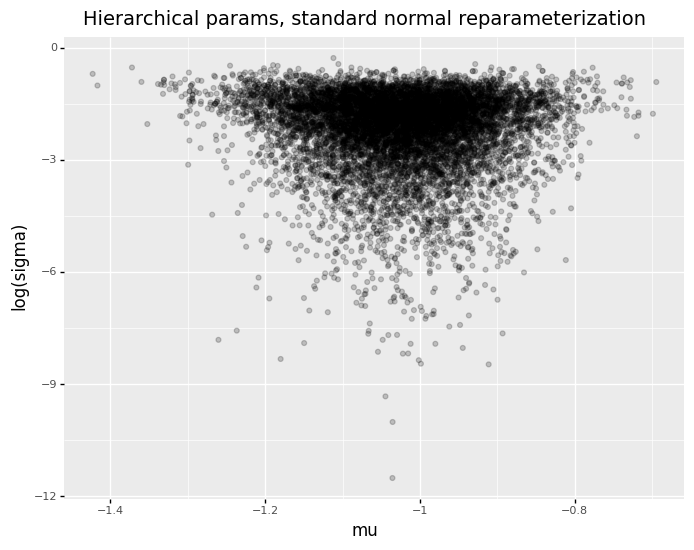

<ggplot: (8775323740462)>

In [14]:
df_x_y = pd.DataFrame(data={'x': fit_nc_std_norm.stan_variable('mu'),
                            'y': np.log(fit_nc_std_norm.stan_variable('sigma'))})

bda_plot(df_x_y,
         x_lab = "mu",
         y_lab = "log(sigma)",
         title = "Hierarchical params, standard normal reparameterization")

Now when we plot the sample values for log scale and the first transformed parameter, `alpha_std[1]`,
the range on the Y axis is (-12, 0) and the narrow funnel neck is gone.   But the values on the X axis range from -3 to 4, and are not directly interpretable as the log odds of success.

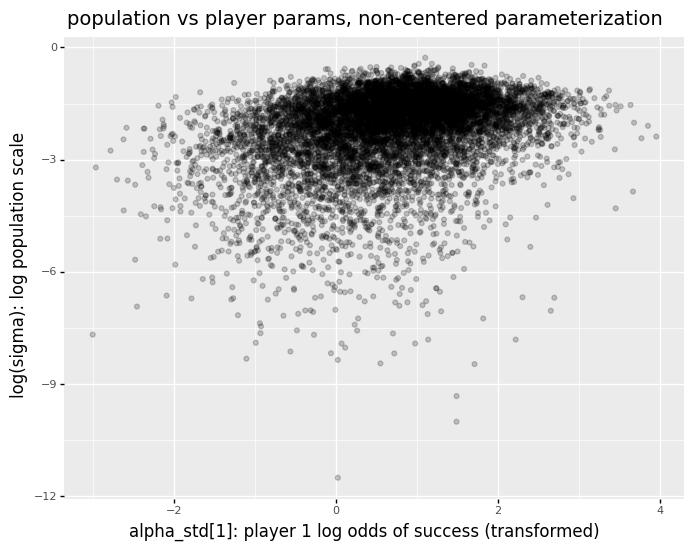

<ggplot: (8775359187604)>

In [15]:
df_x_y_71 = pd.DataFrame(
    data={'x': fit_nc_std_norm.stan_variable('alpha_std')[: , 0],
          'y': np.log(fit_nc_std_norm.stan_variable('sigma'))}
)

bda_plot(df_x_y_71,
         x_lab = "alpha_std[1]: player 1 log odds of success (transformed)",
         y_lab = "log(sigma): log population scale",
         title = "population vs player params, non-centered parameterization")

We can also plot the value for the generated quantities variable `alpha[1]`.
This is readily interpretable as the log odds of success.
The y-axis ranges from (-12, 0).
There isn't a pileup of draws at the bottom, indicating that the sampler has been able
to explore the posterior.
But it still has the long-tail problem as `sigma` approaches zero.

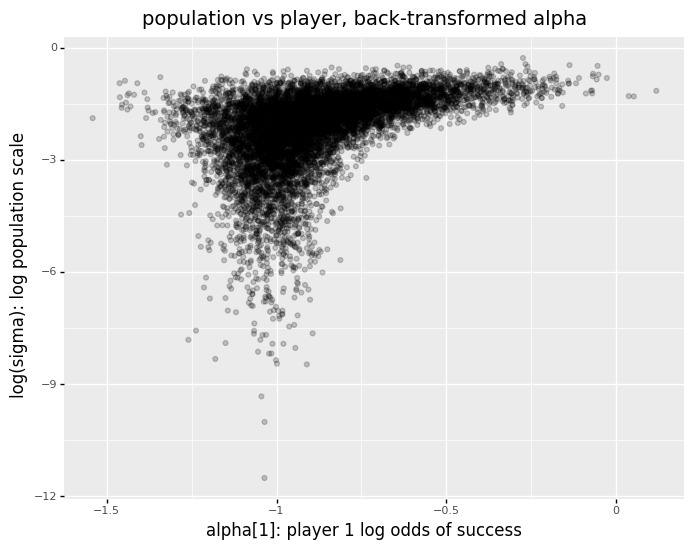

<ggplot: (8775323866829)>

In [16]:
df_x_y_71 = pd.DataFrame(
    data={'x': fit_nc_std_norm.stan_variable('alpha')[: , 0],
          'y': np.log(fit_nc_std_norm.stan_variable('sigma'))}
)

bda_plot(df_x_y_71,
         x_lab = "alpha[1]: player 1 log odds of success",
         y_lab = "log(sigma): log population scale",
         title = "population vs player, back-transformed alpha")

### Fitting the affine transform parameterization

The model `hier-logit-nc-affine-xform.stan` looks just like the centered parameterization,
with the exception that parameter `alpha` is defined with `<offset = mu, multiplier = sigma>`.

In [ ]:
nc_affine_xform_model = CmdStanModel(stan_file='hier-logit-nc-affine-xform.stan')
print(nc_affine_xform_model.code())

In [ ]:
fit_nc_affine = nc_affine_xform_model.sample(
    data=baseball_data,
    iter_sampling=int(M/4),
    seed=54321)

As usual, we check for problems by running CmdStan's diagnose method.

In [ ]:
print(fit_nc_affine.diagnose())

In [ ]:
print("Centered parameterization")
print(fit_centered.summary(sig_figs=3).round(decimals=3).filter(
    ["mu", "sigma",
     "theta[1]", "theta[5]", "theta[10]", "theta[18]",
     "alpha[1]", "alpha[5]", "alpha[10]", "alpha[18]"],
    axis="index"))

print("\nNon-centered parameterization, std_normal reparameterization")
print(fit_nc_std_norm.summary(sig_figs=3).round(decimals=3).filter(
    ["mu", "sigma",
     "theta[1]", "theta[5]", "theta[10]", "theta[18]",
     "alpha[1]", "alpha[5]", "alpha[10]", "alpha[18]"],
    axis="index"))

print("\nNon-centered parameterization, affine transform reparameterization")
print(fit_nc_affine.summary(sig_figs=3).round(decimals=3).filter(
    ["mu", "sigma",
     "theta[1]", "theta[5]", "theta[10]", "theta[18]",
     "alpha[1]", "alpha[5]", "alpha[10]", "alpha[18]"],
    axis="index"))


We plot the sample values for log scale and the first player ability parameter, `alpha[1]`;
this looks pretty much the same as the above plot.

In [ ]:
df_x_y_71 = pd.DataFrame(
    data={'x': fit_nc_affine.stan_variable('alpha')[: , 0],
          'y': np.log(fit_nc_affine.stan_variable('sigma'))}
)

bda_plot(df_x_y_71,
         x_lab = "alpha[1]: player 1 log odds of success",
         y_lab = "log(sigma): log population scale",
         title = "population vs player params, affine transform")

Both `hier-logit-nc-std-norm.stan` and `hier-logit-nc-affine-xform.stan` produce essentially
the same results; this is because both models are essentially the same model:
they encode the non-centered parameterization.

Using the affine transform syntax allows us to write models which directly express the hierarchical structure of the model and which are therefore readily interpretable, unlike the standard normal parameter values.
The only difference is that for the standard normal parameterization
the user must apply the affine transform throughout the program to recover
an interpretable parameter estimate, whereas the use of the offset-multiplier construct
does this automatically.

In program `hier-logit-nc-std-norm.stan`
variable `alpha_std` is a parameter with prior `std_normal()`.
The user specifies the affine transform `mu + sigma * alpha_std`
everywhere.

In the generated quantities block we recover `theta`,
our estimate of a player's chance of success,
and `alpha`, the log-odds of success.
```
generated quantities {
  vector[N] theta = inv_logit(mu + sigma * alpha_std);
  vector[N] alpha = mu + sigma * alpha_std;  // recover alpha
}
```

In program `hier-logit-nc-affine-xform.stan`
variable `alpha` is a parameter with hierarchical prior `normal(mu, sigma)`.
In the generated quantities block we recover `theta`,
our estimate of a player's chance of success.
Were there a need for it, we would be able to generate variable `alpha_std`
as well.

```
generated quantities {
  vector[N] theta = inv_logit(alpha);
  vector[N] alpha_std = (alpha - mu)/sigma;
}
```

To verify that this is correct, we plot `alpha_std[1]` against `log(sigma)`.

In [ ]:
df_x_y_71 = pd.DataFrame(
    data={'x': fit_nc_affine.stan_variable('alpha_std')[: , 0],
          'y': np.log(fit_nc_affine.stan_variable('sigma'))}
)

bda_plot(df_x_y_71,
         x_lab = "alpha_std[1]: player 1 log odds of success (transformed)",
         y_lab = "log(sigma): log population scale",
         title = "population vs player params, non-centered parameterization")